In [1]:
import pandas as pd
# pd.set_option("display.max_rows", None, "display.max_columns", None)
import os
# pd.set_option('display.max_colwidth', -1)    # stop the column text truncating... 
# pd.set_option("display.max_rows", None, "display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyproj import Geod
import contextily as ctx



# to successfully install geopandas first run ---> pip install pyproj==2.2.0
import geopandas as gp

from shapely.geometry import Point

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter


### CCG Geograhpical Boundaries 

The aim of this notebook is to answer the following questions 

* (Important - answer first) Does the team have the correct CCGs in the inner and outer region?
    * can we check this be inferring a distance from heathrow and checking the ccg boundaries are inside/outside?

* (Later question) Is there a way to have a map with heathrow, CCGs, GPS and the air monitoring stations? 


todo remaining:
* important... --> get lat/longitutes from other airports in LONDON... (and luton?)
* (extended) search for GP lat,long points (what can you use to get lat long points etc) 


DONE 
> * map the airport points on the graph (heathrow etc), copy https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972
> * use pandas... to calculate the different distances from heathrow airport
> * you can then limit ccgs based on the distance from midpoint (given in shape descriptiomn)


Findings:
* discuss East Berkshire

In [2]:
# Data Source
# https://geoportal.statistics.gov.uk/search?q=clinical%20comissioning%20groups

# MOST USEFUL ONE Mapping with the SHAPE FILES...
# https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972




# others
# https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
    # accompanying link containing borough files https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london

# overlay midpoint

# this method is quite complicated (try geopandas first as it had a lower barrier of entry & is similar to pandas)
# https://towardsdatascience.com/mapping-geograph-data-in-python-610a963d2d7f

        # after... we will need to learn how to put points on the shape file... as a next step 

# https://geoportal.statistics.gov.uk/datasets/clinical-commissioning-groups-april-2019-names-and-codes-in-england
# VECTOR BOUNDARIES AND SHAPE FILES...

# https://towardsdatascience.com/a-complete-guide-to-an-interactive-geographical-map-using-python-f4c5197e23e0
# * geopandas...


# plotting basemap (also showed how to change the crs mode (required for coordinate here)) https://geopandas.org/gallery/plotting_basemap_background.html

In [3]:
# remember to keep the geometry field truncated... (otherwise this ruins head)
shp_filepath = 'Clinical_Commissioning_Groups__April_2019__Boundaries_EN_BFC-shp/Clinical_Commissioning_Groups__April_2019__Boundaries_EN_BFC.shp'

ldn_map_df = gp.read_file(shp_filepath)

# # check data type so we can see that this is not a normal dataframe, but a GEOdataframe
ldn_map_df.head(10)

# convert the df to lat,long format (required)
ldn_map_df = ldn_map_df.to_crs(epsg=4326)

# altetnaticve way to convert format (see below)
crs = {'init': 'epsg:4326'}

In [4]:
# create airport df so we can visualise them on the map

data = {'LOC_NAME':['Heathrow Airport'],
        'LONG':[-0.454295],
        'LAT': [51.470020],
        'geometry': ['empty'],  
       }
df = pd.DataFrame(data)

# create geometry column
geometry = [Point(xy) for xy in zip(df['LONG'], df['LAT'])]
df.geometry = geometry

# convert the airports df into a geo_df (so that it plots...)
geo_df_airport = gp.GeoDataFrame(df, crs=crs)

geo_df_airport.head()

/Users/gaylej/.virtualenvs/aa_at_py3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,LOC_NAME,LONG,LAT,geometry
0,Heathrow Airport,-0.454295,51.47002,POINT (-0.45430 51.47002)


<AxesSubplot:>

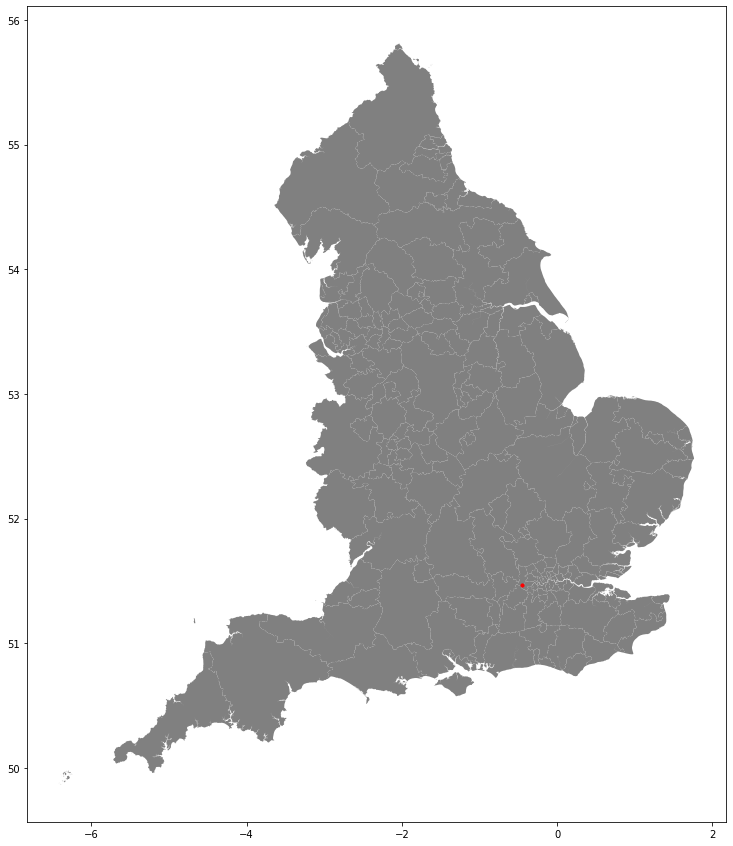

In [5]:
# plot the heathrow airport as a overlay on our ccg map... 

fig, ax = plt.subplots(figsize=(15,15))
ldn_map_df.plot(ax=ax, color='grey',)
geo_df_airport.plot(ax=ax, markersize=10, color='red', marker='o')


## Limit the CCGs

We will now use distancing (from the midpoint of the ccg region), to determine the CCGs to keep around heathrow 

In [6]:
# resources
# https://gis.stackexchange.com/questions/279109/calculate-distance-between-a-coordinate-and-a-county-in-geopandas

ldn_map_df.head()


,OBJECTID,CCG19CD,CCG19NM,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry
0,1,E38000001,"NHS Airedale, Wharfedale and Craven CCG",393990,462191,-2.093300,54.0556,1.220633e+09,222000.154543,"POLYGON ((-2.00450 54.17287, -2.00421 54.17268..."
1,2,E38000002,NHS Ashford CCG,597640,140644,0.823374,51.1310,5.806172e+08,149426.082727,"POLYGON ((1.00394 51.18005, 1.00391 51.18004, ..."
2,3,E38000004,NHS Barking and Dagenham CCG,547758,185109,0.129493,51.5455,3.609104e+07,40665.310992,"MULTIPOLYGON (((0.06913 51.53881, 0.06935 51.5..."
3,4,E38000005,NHS Barnet CCG,523471,191753,-0.218220,51.6111,8.673644e+07,50842.313101,"POLYGON ((-0.18211 51.66860, -0.18233 51.66826..."
4,5,E38000006,NHS Barnsley CCG,429979,403330,-1.549250,53.5258,3.290521e+08,125518.601736,"POLYGON ((-1.34865 53.58331, -1.34843 53.58324..."


In [7]:
# get distance between two lat long points
# https://stackoverflow.com/questions/44446862/calculate-distance-between-latitude-and-longitude-in-dataframe

heathrow_lat, heathrow_lon = 51.47002, -0.454295

# https://pyproj4.github.io/pyproj/stable/api/geod.html
wgs84_geod = Geod(ellps='WGS84') #Distance will be measured on this ellipsoid - more accurate than a spherical method

def get_distance(lat1, lon1, lat2, lon2):
    # distance is returned in metres (cross-checked on site)
    az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2) 
    return(dist)
    
def calc_heathrow_dist(row):
    return get_distance(heathrow_lat, heathrow_lon, row['LAT'], row['LONG'])


def calc_heathrow_dist_from_latlong(lat_long):
    try:
        return get_distance(heathrow_lat, heathrow_lon, lat_long[0], lat_long[1]) 
    except TypeError:
        print(lat_long)
        return 'nothing'


In [8]:

get_distance(-0.454295, 51.47002,0.129493, 51.5455)

ldn_map_df_dist = ldn_map_df.copy()

ldn_map_df_dist['heathrow_distance'] = ldn_map_df_dist.apply(calc_heathrow_dist, axis=1)

In [9]:
output = pd.DataFrame(ldn_map_df_dist.copy())
output.rename(columns={'CCG19NM': 'Area Name'}, inplace=True)
output.drop(columns=['geometry'], inplace=True)
output.to_csv('nhs_ccg_geometry.csv')

/Users/gaylej/.virtualenvs/aa_at_py3/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
<ipython-input-39-680fb80ca8fe>:20: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=row['CCG19NM'], xy=row['coords'],
<ipython-input-39-680fb80ca8fe>:25: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=row['LOC_NAME'], xy=((row['LONG'], row['LAT'])),


['NHS Barking and Dagenham CCG' 'NHS Barnet CCG' 'NHS Bexley CCG'
 'NHS Brent CCG' 'NHS Bromley CCG' 'NHS Camden CCG'
 'NHS Central London (Westminster) CCG' 'NHS City and Hackney CCG'
 'NHS Crawley CCG' 'NHS Croydon CCG' 'NHS Ealing CCG'
 'NHS East Surrey CCG' 'NHS Enfield CCG' 'NHS Greenwich CCG'
 'NHS Hammersmith and Fulham CCG' 'NHS Haringey CCG' 'NHS Harrow CCG'
 'NHS Havering CCG' 'NHS Herts Valleys CCG' 'NHS Hillingdon CCG'
 'NHS Hounslow CCG' 'NHS Islington CCG' 'NHS Kingston CCG'
 'NHS Lambeth CCG' 'NHS Lewisham CCG' 'NHS Luton CCG' 'NHS Merton CCG'
 'NHS Newham CCG' 'NHS North East Hampshire and Farnham CCG'
 'NHS North West Surrey CCG' 'NHS Redbridge CCG' 'NHS Richmond CCG'
 'NHS Southwark CCG' 'NHS Surrey Downs CCG' 'NHS Surrey Heath CCG'
 'NHS Sutton CCG' 'NHS Tower Hamlets CCG' 'NHS Waltham Forest CCG'
 'NHS Wandsworth CCG' 'NHS West London CCG'
 'NHS Guildford and Waverley CCG' 'NHS Berkshire West CCG'
 'NHS Buckinghamshire CCG' 'NHS East Berkshire CCG']


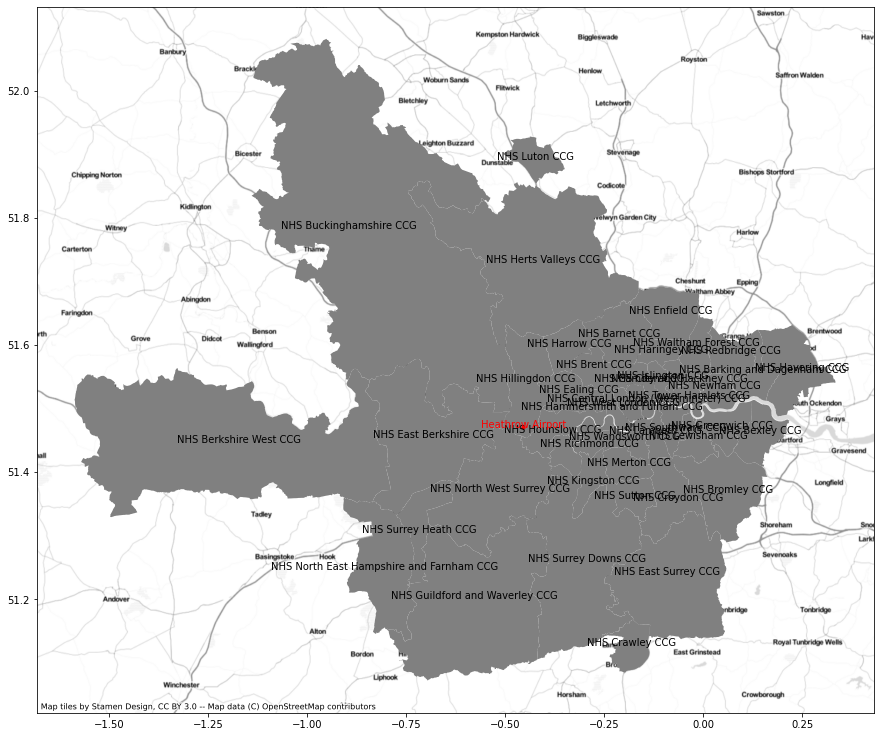

In [39]:

smaller_df = ldn_map_df_dist[ldn_map_df_dist['heathrow_distance'] <= 50000]

# solution inspired by stackoverflow. can also use (long,lat) as the midpoint
# https://stackoverflow.com/questions/38899190/geopandas-label-polygons
smaller_df['coords'] = smaller_df['geometry'].apply(lambda x: x.representative_point().coords[:])
smaller_df['coords'] = [coords[0] for coords in smaller_df['coords']]


fig, ax = plt.subplots(figsize=(15,15))
smaller_df.plot(ax=ax, color='grey',)

# ctx.add_basemap(ax, zoom=12)
geo_df_airport.plot(ax=ax, markersize=10, color='red', marker='o')

# plot the names on the midpoints
for idx, row in smaller_df.iterrows():
    plt.annotate(s=row['CCG19NM'], xy=row['coords'],
                 horizontalalignment='center')
    
# do the same for the airports (complete airport_df tomorrow)    
for idx, row in geo_df_airport.iterrows():
    plt.annotate(s=row['LOC_NAME'], xy=((row['LONG'], row['LAT'])),
                 horizontalalignment='center', color='red')
    

print(smaller_df.CCG19NM.unique())


In [11]:
inner_ccgs = ['NHS Buckinghamshire CCG', 'NHS Ealing CCG', 'NHS East Berkshire CCG', 'NHS Hillingdon CCG',
 'NHS Hounslow CCG', 'NHS North West Surrey CCG']

outer_ccgs =  ['NHS Basildon And Brentwood CCG', 'NHS Berkshire West CCG', 'NHS Brent CCG', 'NHS Croydon CCG',
               'NHS Guildford and Waverley CCG', 'NHS Hammersmith And Fulham CCG', 'NHS Harrow CCG', 
               'NHS Herts Valleys CCG', 'NHS Kingston CCG', 'NHS Merton CCG', 'NHS Oxfordshire CCG', 
               'NHS Richmond CCG', 'NHS Surrey Heath CCG', 'NHS Sutton CCG', 'NHS Wandsworth CCG']

## Part 2: Plot Other Points of Interest on The Map (Airports... GPs etc.)

### Overlaying airports

In [12]:
# Inspired by https://towardsdatascience.com/geocode-with-python-161ec1e62b89

locator = Nominatim(user_agent='myGeocoder')
location = locator.geocode('Heathrow Airport, England')

In [13]:
print((location.raw))

{'place_id': 134195200, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'way', 'osm_id': 185882029, 'boundingbox': ['51.4560987', '51.4794056', '-0.4943776', '-0.4151697'], 'lat': '51.46773895', 'lon': '-0.4587800741571181', 'display_name': 'London Heathrow Airport, Gleneagles Close, Stanwell, Spelthorne, Surrey, South East, England, TW19 7NP, United Kingdom', 'class': 'aeroway', 'type': 'aerodrome', 'importance': 0.8661714371841469, 'icon': 'https://nominatim.openstreetmap.org/ui/mapicons//transport_airport2.p.20.png'}


In [14]:
# build a dataframe from a series of airport locations... 
# https://gis.stackexchange.com/questions/331144/bulk-reverse-geocoding-with-geopy-using-built-in-rate-limiter
airport_list_dict = []

Airports = ['London City Airport', 'London Gatwick Airport', 'London Heathrow Airport', 'London Luton Airport', 'London Stansted Airport', 'London Southend Airport']

geocode = RateLimiter(locator.geocode, min_delay_seconds=0.2)

for airport in Airports:
    address = (geocode(airport))
    airport_list_dict.append(
    {
      'NAME'  : airport,
      'ADDRESS'  : address,
      'LONG'  : address.longitude,
      'LAT'  : address.latitude,
    }
    )

airport_df = pd.DataFrame(airport_list_dict)
airport_geo = gp.GeoDataFrame(airport_df, geometry=gp.points_from_xy(airport_df['LONG'], airport_df['LAT']))
airport_geo.head()

,NAME,ADDRESS,LONG,LAT,geometry
0,London City Airport,"(London City Airport, Hartmann Road, Galleons ...",0.054913,51.504266,POINT (0.05491 51.50427)
1,London Gatwick Airport,"(London Gatwick Airport, Povey Cross Road, Cra...",-0.180388,51.154106,POINT (-0.18039 51.15411)
2,London Heathrow Airport,"(London Heathrow Airport, Gleneagles Close, St...",-0.458780,51.467739,POINT (-0.45878 51.46774)
3,London Luton Airport,"(London Luton Airport, Percival Way, Wigmore, ...",-0.366457,51.878140,POINT (-0.36646 51.87814)
4,London Stansted Airport,"(London Stansted Airport, Terminal Road South,...",0.244193,51.886965,POINT (0.24419 51.88697)


<ipython-input-15-acafc62c3562>:17: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=row['NAME'], xy=((row['LONG'], row['LAT'])),


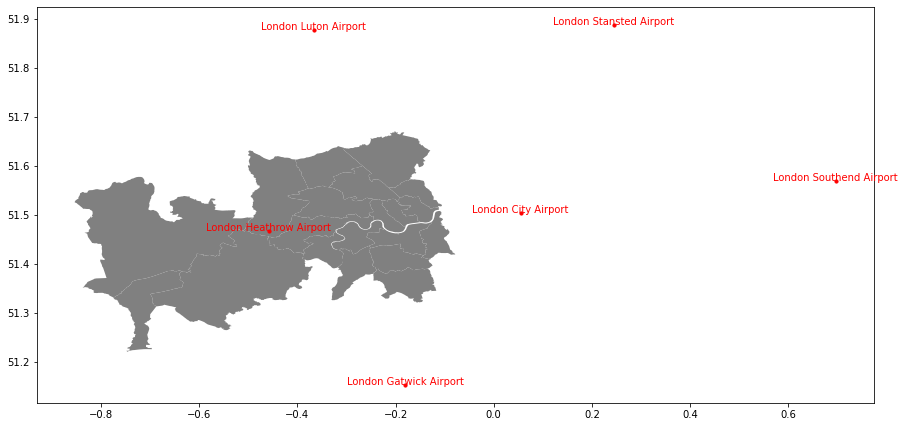

In [15]:
ccg_df = ldn_map_df_dist[ldn_map_df_dist['heathrow_distance'] <= 25000]


fig, ax = plt.subplots(figsize=(15,15))
ccg_df.plot(ax=ax, color='grey')
airport_geo.plot(ax=ax, markersize=10, color='red', marker='o')


# plot names for the boroughs
# for idx, row in ccg_df.iterrows():
#     plt.annotate(s=row['CCG19NM'], xy=((row['LONG'], row['LAT'])),
#                  horizontalalignment='center')
    

# plot names for the airports (complete airport_df tomorrow)    
for idx, row in airport_geo.iterrows():
    plt.annotate(s=row['NAME'], xy=((row['LONG'], row['LAT'])),
                 horizontalalignment='center', color='red')

### Overlaying GPs

In [16]:
# pull in GP data:

qof_full_gp = pd.read_csv('../fingertips/data_output/nhs_qof_dataset/nhs_qof_dataset.csv')


#restrict to GP
qof_full_gp = qof_full_gp[qof_full_gp['Area Type'] == 'GP']

qof_full_gp.head()

/Users/gaylej/.virtualenvs/aa_at_py3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10,11,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,Indicator ID,Indicator Name,Parent Code,Parent Name,Area Code,Area Name,Area Type,Sex,Age,...,Upper CI 99.8 limit,Count,Denominator,Value note,Recent Trend,Compared to England value or percentiles,Compared to percentiles,Time period Sortable,New data,Compared to goal
26390,26390,219,Hypertension: QOF prevalence (all ages),E92000001,England,A81001,The Densham Surgery,GP,Persons,All ages,...,NaN,579.0,4164.0,NaN,NaN,Similar,Not compared,20090000,NaN,NaN
26391,26391,219,Hypertension: QOF prevalence (all ages),E92000001,England,A81002,Queens Park Medical Centre,GP,Persons,All ages,...,NaN,3225.0,20588.0,NaN,NaN,Higher,Not compared,20090000,NaN,NaN
26392,26392,219,Hypertension: QOF prevalence (all ages),E92000001,England,A81004,Bluebell Medical Centre,GP,Persons,All ages,...,NaN,1230.0,8271.0,NaN,NaN,Higher,Not compared,20090000,NaN,NaN
26393,26393,219,Hypertension: QOF prevalence (all ages),E92000001,England,A81005,Springwood Surgery,GP,Persons,All ages,...,NaN,1376.0,7972.0,NaN,NaN,Higher,Not compared,20090000,NaN,NaN
26394,26394,219,Hypertension: QOF prevalence (all ages),E92000001,England,A81006,Tennant Street Medical Practice,GP,Persons,All ages,...,NaN,1863.0,12365.0,NaN,NaN,Higher,Not compared,20090000,NaN,NaN


In [17]:
# # alternative - google maps --> this could be charged... 
# # https://stackoverflow.com/questions/6159074/given-the-lat-long-coordinates-how-can-we-find-out-the-city-country
# import geopandas as gp

# qof_gps = qof_full_gp['Area Name'].unique()
# print(len(qof_gps))
# qof_gp_lst_dict = []

# counter= 0

# for gp_name in qof_gps[0:50]:
#     counter += 1
#     print('sourcing address for GP {0} out of {1}'.format(counter, len(qof_gps[0:50])))
#     print('the GP name is: {0}'.format(gp_name))
#     print('\n')
#     try:
#         address = (geocode(gp_name + ', England'))
#         qof_gp_lst_dict.append(
#             {
#               'NAME'  : gp_name,
#               'ADDRESS'  : address,
#               'LONG'  : address.longitude,
#               'LAT'  : address.latitude,
#             }
#         )
#     except AttributeError:
#         qof_gp_lst_dict.append(
#             {
#               'NAME'  : gp_name,
#               'ADDRESS'  : 'Not Found',
#               'LONG'  : None,
#               'LAT'  : None,
#             }
#         )
        
# gp_df = pd.DataFrame(qof_gp_lst_dict)
# gp_geo = gp.GeoDataFrame(gp_df, geometry=gp.points_from_xy(gp_df['LONG'], gp_df['LAT']))
# gp_geo.head()


In [18]:
def get_long_lat(row):
    print('sourcing address for {0}'.format(row['NAME']))
    try:
        address = (geocode(row['ADDRESS']))
        return (address.longitude, address.latitude)

    except AttributeError:
        
        try:
            address = (geocode(row['POSTCODE']))
            return (address.longitude, address.latitude)
        
        except AttributeError:
            return None


In [19]:
nhs_gp2= pd.read_csv('epraccur.csv', encoding='utf-8')

nhs_gp2 = nhs_gp2.fillna('')
nhs_gp2['ADDRESS'] = nhs_gp2['ADDRESS_1'] + ', ' + nhs_gp2['ADDRESS_2'] + ', ' + nhs_gp2['ADDRESS_3'] + ', ' + nhs_gp2['POSTCODE'] 

In [20]:
nhs_gp2.head()

,ORG_CODE,NAME,NATIONAL_GROUPING,HEALTH_GEOG,ADDRESS_1,ADDRESS_2,ADDRESS_3,ADDRESS_4,ADDRESS_5,POSTCODE,...,STATUS_CODE,ORG_SUB_CODE,COMMISIONER_CODE,JOIN_PROVIDER_DATE,LEFT_PROVIDER_DATE,TELE,RECORD_AMENDED,PROVIDER_PURCHASER,PRESCRIBING_SETTING,ADDRESS
0,A81001,THE DENSHAM SURGERY,Y63,QHM,THE HEALTH CENTRE,LAWSON STREET,STOCKTON-ON-TEES,CLEVELAND,,TS18 1HU,...,A,B,16C,2.02004e+07,,01642 672351,0,16C,4,"THE HEALTH CENTRE, LAWSON STREET, STOCKTON-ON-..."
1,A81002,QUEENS PARK MEDICAL CENTRE,Y63,QHM,QUEENS PARK MEDICAL CTR,FARRER STREET,STOCKTON ON TEES,CLEVELAND,,TS18 2AW,...,A,B,16C,2.02004e+07,,01642 679681,0,16C,4,"QUEENS PARK MEDICAL CTR, FARRER STREET, STOCKT..."
2,A81003,VICTORIA MEDICAL PRACTICE,Y54,Q74,THE HEALTH CENTRE,VICTORIA ROAD,HARTLEPOOL,CLEVELAND,,TS26 8DB,...,C,B,00K,2.01304e+07,2.0171e+07,01429 272945,0,00K,4,"THE HEALTH CENTRE, VICTORIA ROAD, HARTLEPOOL, ..."
3,A81004,BLUEBELL MEDICAL CENTRE,Y63,QHM,TRIMDON AVENUE,ACKLAM,MIDDLESBROUGH,,,TS5 8SB,...,A,B,16C,2.02004e+07,,01642 827697,0,16C,4,"TRIMDON AVENUE, ACKLAM, MIDDLESBROUGH, TS5 8SB"
4,A81005,SPRINGWOOD SURGERY,Y63,QHM,SPRINGWOOD SURGERY,RECTORY LANE,GUISBOROUGH,,,TS14 7DJ,...,A,B,16C,2.02004e+07,,01287 619611,0,16C,4,"SPRINGWOOD SURGERY, RECTORY LANE, GUISBOROUGH,..."


In [21]:
# nhs_gp2['LOCATION'] = nhs_gp2.head(30)['ADDRESS'].apply(geocode)

# nhs_gp2['LOCATION'] = nhs_gp2.apply(get_long_lat, axis=1)


In [22]:
# nhs_gp2.to_csv('nhs_gp_latlong_20210111.CSV', encoding='utf-8')


In [23]:
def calc_heathrow_dist_from_latlong(lat_long):
    return get_distance(heathrow_lat, heathrow_lon, lat_long[0], lat_long[1]) 

In [24]:
nhs_gp2 = pd.read_csv('nhs_gp_latlong_20210111.CSV', encoding='utf-8')

In [25]:
nhs_gp2.head()

,Unnamed: 0,ORG_CODE,NAME,NATIONAL_GROUPING,HEALTH_GEOG,ADDRESS_1,ADDRESS_2,ADDRESS_3,ADDRESS_4,ADDRESS_5,...,ORG_SUB_CODE,COMMISIONER_CODE,JOIN_PROVIDER_DATE,LEFT_PROVIDER_DATE,TELE,RECORD_AMENDED,PROVIDER_PURCHASER,PRESCRIBING_SETTING,ADDRESS,LOCATION
0,0,A81001,THE DENSHAM SURGERY,Y63,QHM,THE HEALTH CENTRE,LAWSON STREET,STOCKTON-ON-TEES,CLEVELAND,NaN,...,B,16C,20200401.0,NaN,01642 672351,0,16C,4,"THE HEALTH CENTRE, LAWSON STREET, STOCKTON-ON-...","(-1.3184148, 54.5611002)"
1,1,A81002,QUEENS PARK MEDICAL CENTRE,Y63,QHM,QUEENS PARK MEDICAL CTR,FARRER STREET,STOCKTON ON TEES,CLEVELAND,NaN,...,B,16C,20200401.0,NaN,01642 679681,0,16C,4,"QUEENS PARK MEDICAL CTR, FARRER STREET, STOCKT...","(-1.313866888882218, 54.56917125)"
2,2,A81003,VICTORIA MEDICAL PRACTICE,Y54,Q74,THE HEALTH CENTRE,VICTORIA ROAD,HARTLEPOOL,CLEVELAND,NaN,...,B,00K,20130401.0,20171031.0,01429 272945,0,00K,4,"THE HEALTH CENTRE, VICTORIA ROAD, HARTLEPOOL, ...","(-1.2195137, 54.6854736)"
3,3,A81004,BLUEBELL MEDICAL CENTRE,Y63,QHM,TRIMDON AVENUE,ACKLAM,MIDDLESBROUGH,NaN,NaN,...,B,16C,20200401.0,NaN,01642 827697,0,16C,4,"TRIMDON AVENUE, ACKLAM, MIDDLESBROUGH, TS5 8SB","(-1.2622495, 54.5399797)"
4,4,A81005,SPRINGWOOD SURGERY,Y63,QHM,SPRINGWOOD SURGERY,RECTORY LANE,GUISBOROUGH,NaN,NaN,...,B,16C,20200401.0,NaN,01287 619611,0,16C,4,"SPRINGWOOD SURGERY, RECTORY LANE, GUISBOROUGH,...","(-1.0531021, 54.5329389)"


In [26]:
# nhs_gp2[['lat', 'long']] = pd.DataFrame(nhs_gp2['LOCATION'].tolist(), index=nhs_gp2.index) 

nhs_3 = pd.concat([nhs_gp2, nhs_gp2['LOCATION'].str[1:-1].str.split(',', expand=True).astype(float)], axis=1).rename(columns={0:'LONG', 1:'LAT'})
nhs_3

,Unnamed: 0,ORG_CODE,NAME,NATIONAL_GROUPING,HEALTH_GEOG,ADDRESS_1,ADDRESS_2,ADDRESS_3,ADDRESS_4,ADDRESS_5,...,JOIN_PROVIDER_DATE,LEFT_PROVIDER_DATE,TELE,RECORD_AMENDED,PROVIDER_PURCHASER,PRESCRIBING_SETTING,ADDRESS,LOCATION,LONG,LAT
0,0,A81001,THE DENSHAM SURGERY,Y63,QHM,THE HEALTH CENTRE,LAWSON STREET,STOCKTON-ON-TEES,CLEVELAND,NaN,...,20200401.0,NaN,01642 672351,0,16C,4,"THE HEALTH CENTRE, LAWSON STREET, STOCKTON-ON-...","(-1.3184148, 54.5611002)",-1.318415,54.561100
1,1,A81002,QUEENS PARK MEDICAL CENTRE,Y63,QHM,QUEENS PARK MEDICAL CTR,FARRER STREET,STOCKTON ON TEES,CLEVELAND,NaN,...,20200401.0,NaN,01642 679681,0,16C,4,"QUEENS PARK MEDICAL CTR, FARRER STREET, STOCKT...","(-1.313866888882218, 54.56917125)",-1.313867,54.569171
2,2,A81003,VICTORIA MEDICAL PRACTICE,Y54,Q74,THE HEALTH CENTRE,VICTORIA ROAD,HARTLEPOOL,CLEVELAND,NaN,...,20130401.0,20171031.0,01429 272945,0,00K,4,"THE HEALTH CENTRE, VICTORIA ROAD, HARTLEPOOL, ...","(-1.2195137, 54.6854736)",-1.219514,54.685474
3,3,A81004,BLUEBELL MEDICAL CENTRE,Y63,QHM,TRIMDON AVENUE,ACKLAM,MIDDLESBROUGH,NaN,NaN,...,20200401.0,NaN,01642 827697,0,16C,4,"TRIMDON AVENUE, ACKLAM, MIDDLESBROUGH, TS5 8SB","(-1.2622495, 54.5399797)",-1.262250,54.539980
4,4,A81005,SPRINGWOOD SURGERY,Y63,QHM,SPRINGWOOD SURGERY,RECTORY LANE,GUISBOROUGH,NaN,NaN,...,20200401.0,NaN,01287 619611,0,16C,4,"SPRINGWOOD SURGERY, RECTORY LANE, GUISBOROUGH,...","(-1.0531021, 54.5329389)",-1.053102,54.532939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14697,14697,Y06927,DCHS URGENT TREATMENT CENTRE,Y60,QJ2,WALTON HOSPITAL,WHITECOTES LANE,CHESTERFIELD,DERBYSHIRE,NaN,...,20201101.0,NaN,01246 515633,1,RY8,9,"WALTON HOSPITAL, WHITECOTES LANE, CHESTERFIELD...","(-1.4413681693059541, 53.22149085)",-1.441368,53.221491
14698,14698,Y06928,AYCLIFFE SECURE CENTRE,Y63,Q99,COPELAW,NaN,NEWTON AYCLIFFE,COUNTY DURHAM,NaN,...,20201109.0,NaN,03000 263000,1,76A,18,"COPELAW, , NEWTON AYCLIFFE, DL5 6JB","(-1.5515781020851394, 54.622840725055575)",-1.551578,54.622841
14699,14699,Y06929,SS9 PCN,Y61,QH8,918 LONDON ROAD,LEIGH ON SEA,ESSEX,NaN,NaN,...,20201101.0,NaN,07885 287904,1,99G,0,"918 LONDON ROAD, LEIGH ON SEA, ESSEX, SS9 3NG","(0.625917, 51.5490978)",0.625917,51.549098
14700,14700,Y06930,HILLTON PCN,Y61,QHG,HOUGHTON CLOSE SURGERY,1 HOUGHTON CLOSE,AMPHTILL,BEDFORDSHIRE,NaN,...,20201201.0,NaN,01525 844991,1,06F,0,"HOUGHTON CLOSE SURGERY, 1 HOUGHTON CLOSE, AMPH...","(-0.4942302858770796, 52.02557531890242)",-0.494230,52.025575


In [27]:
# nhs_gp2['heathrow_distance'] = nhs_gp2['LOCATION'].apply(calc_heathrow_dist_from_latlong)
nhs_3['heathrow_distance'] = nhs_3.apply(calc_heathrow_dist, axis=1)

In [28]:
gp_geo = gp.GeoDataFrame(nhs_3, geometry=gp.points_from_xy(nhs_3['LONG'], nhs_3['LAT']))
gp_geo.head()

,Unnamed: 0,ORG_CODE,NAME,NATIONAL_GROUPING,HEALTH_GEOG,ADDRESS_1,ADDRESS_2,ADDRESS_3,ADDRESS_4,ADDRESS_5,...,TELE,RECORD_AMENDED,PROVIDER_PURCHASER,PRESCRIBING_SETTING,ADDRESS,LOCATION,LONG,LAT,heathrow_distance,geometry
0,0,A81001,THE DENSHAM SURGERY,Y63,QHM,THE HEALTH CENTRE,LAWSON STREET,STOCKTON-ON-TEES,CLEVELAND,NaN,...,01642 672351,0,16C,4,"THE HEALTH CENTRE, LAWSON STREET, STOCKTON-ON-...","(-1.3184148, 54.5611002)",-1.318415,54.561100,348842.333865,POINT (-1.31841 54.56110)
1,1,A81002,QUEENS PARK MEDICAL CENTRE,Y63,QHM,QUEENS PARK MEDICAL CTR,FARRER STREET,STOCKTON ON TEES,CLEVELAND,NaN,...,01642 679681,0,16C,4,"QUEENS PARK MEDICAL CTR, FARRER STREET, STOCKT...","(-1.313866888882218, 54.56917125)",-1.313867,54.569171,349676.983415,POINT (-1.31387 54.56917)
2,2,A81003,VICTORIA MEDICAL PRACTICE,Y54,Q74,THE HEALTH CENTRE,VICTORIA ROAD,HARTLEPOOL,CLEVELAND,NaN,...,01429 272945,0,00K,4,"THE HEALTH CENTRE, VICTORIA ROAD, HARTLEPOOL, ...","(-1.2195137, 54.6854736)",-1.219514,54.685474,361490.188752,POINT (-1.21951 54.68547)
3,3,A81004,BLUEBELL MEDICAL CENTRE,Y63,QHM,TRIMDON AVENUE,ACKLAM,MIDDLESBROUGH,NaN,NaN,...,01642 827697,0,16C,4,"TRIMDON AVENUE, ACKLAM, MIDDLESBROUGH, TS5 8SB","(-1.2622495, 54.5399797)",-1.262250,54.539980,345916.416929,POINT (-1.26225 54.53998)
4,4,A81005,SPRINGWOOD SURGERY,Y63,QHM,SPRINGWOOD SURGERY,RECTORY LANE,GUISBOROUGH,NaN,NaN,...,01287 619611,0,16C,4,"SPRINGWOOD SURGERY, RECTORY LANE, GUISBOROUGH,...","(-1.0531021, 54.5329389)",-1.053102,54.532939,343219.586336,POINT (-1.05310 54.53294)


/Users/gaylej/.virtualenvs/aa_at_py3/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
<ipython-input-29-ce75a63ca1bd>:22: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=row['CCG19NM'], xy=row['coords'],
<ipython-input-29-ce75a63ca1bd>:27: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=row['LOC_NAME'], xy=((row['LONG'], row['LAT'])),


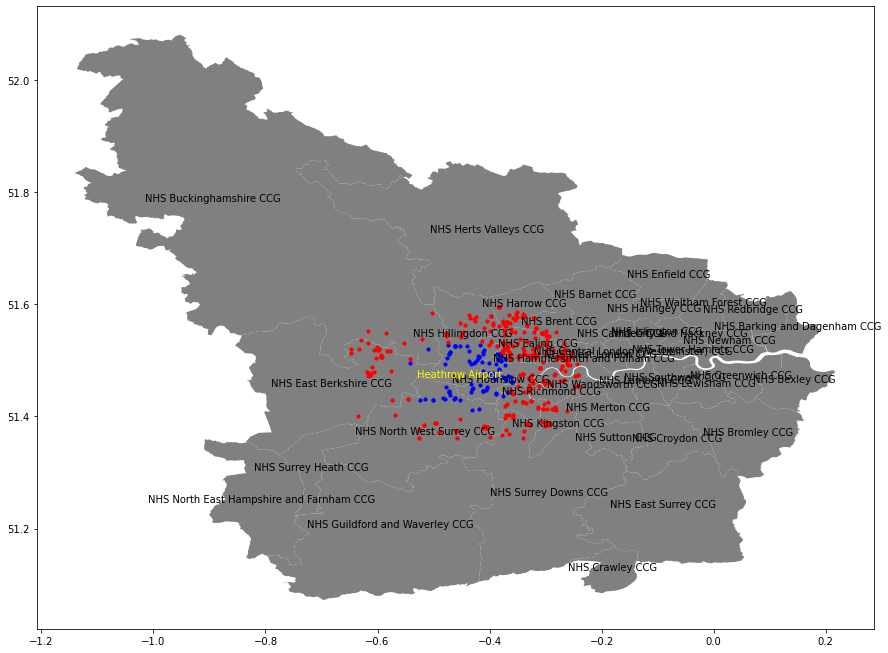

In [29]:
gp_geo_inner = gp_geo[gp_geo['heathrow_distance']<=7000]
gp_geo_outer = gp_geo[(gp_geo['heathrow_distance']>=7000) & (gp_geo['heathrow_distance']<15000)]


smaller_df = ldn_map_df_dist[ldn_map_df_dist['heathrow_distance'] <= 45000]

# solution inspired by stackoverflow. can also use (long,lat) as the midpoint
# https://stackoverflow.com/questions/38899190/geopandas-label-polygons
smaller_df['coords'] = smaller_df['geometry'].apply(lambda x: x.representative_point().coords[:])
smaller_df['coords'] = [coords[0] for coords in smaller_df['coords']]


fig, ax = plt.subplots(figsize=(15,15))
smaller_df.plot(ax=ax, color='grey',)
# airport_geo.plot(ax=ax, markersize=10, color='yellow', marker='o')
geo_df_airport.plot(ax=ax, markersize=10, color='yellow', marker='o')
gp_geo_inner.plot(ax=ax, markersize=10, color='blue', marker='o')
gp_geo_outer.plot(ax=ax, markersize=10, color='red', marker='o')

# plot the names on the midpoints
for idx, row in smaller_df.iterrows():
    plt.annotate(s=row['CCG19NM'], xy=row['coords'],
                 horizontalalignment='center')
    
# do the same for the airports (complete airport_df tomorrow)    
for idx, row in geo_df_airport.iterrows():
    plt.annotate(s=row['LOC_NAME'], xy=((row['LONG'], row['LAT'])),
                 horizontalalignment='center', color='yellow')


### Add Stations and Background to the Map!

In [30]:
# 1. Load in the station files... 
# stations = pd.read_csv('../../data_final/pollution.csv')
stations = pd.read_csv('../../data_final/pollution.csv', converters={'column_name': eval})
stations.head()

,Unnamed: 0,Location,Date,CCG,Radius,lat/long,distance_from_LHR,Pollutant,Indicator Value (R µg/m3)
0,0,Hounslow 2 - Cranford,2004,Hounslow,Inner,"[51.4686132, -0.3613471]",6.440137,Carbon monoxide,NaN
1,1,Hounslow 2 - Cranford,2005,Hounslow,Inner,"[51.4686132, -0.3613471]",6.440137,Carbon monoxide,NaN
2,2,Hounslow 2 - Cranford,2006,Hounslow,Inner,"[51.4686132, -0.3613471]",6.440137,Carbon monoxide,NaN
3,3,Hounslow 2 - Cranford,2007,Hounslow,Inner,"[51.4686132, -0.3613471]",6.440137,Carbon monoxide,NaN
4,4,Hounslow 2 - Cranford,2008,Hounslow,Inner,"[51.4686132, -0.3613471]",6.440137,Carbon monoxide,NaN


In [31]:
stations.drop(columns=[
    'Unnamed: 0',
    'Date',
    'CCG',
    'Radius',
    'Pollutant',
    'Indicator Value (R µg/m3)',    
], inplace=True)

stations.drop_duplicates(inplace=True)

print(stations.shape)
stations.head(10)

(84, 3)


,Location,lat/long,distance_from_LHR
0,Hounslow 2 - Cranford,"[51.4686132, -0.3613471]",6.440137
17,Hounslow 4 - Chiswick High Road,"[51.492507, -0.257252]",13.872241
33,Hounslow Brentford,"[51.4620974, -0.3617294]",6.472446
50,Hounslow Feltham,"[51.4578773, -0.38514812469308957]",4.976826
59,Hounslow Gunnersbury,"[51.500676, -0.284383]",12.249057
68,Hounslow Hatton Cross,"[51.463402, -0.427525]",1.995066
83,Hounslow Heston Road,"[51.4735822, -0.3858181]",4.759453
98,Ealing - Acton Town Hall,"[51.50663616079527, -0.2678132745985841]",13.538415
107,Ealing - Acton Town Hall (Partisol),"[51.506675749015194, -0.26802731507705546]",13.525602
109,Ealing - Acton Town Hall FDMS,"[51.5068159264046, -0.26836391507706425]",13.508076


In [32]:
# convert the string into a list, then get lat longs
import ast
stations['LAT'] = stations['lat/long'].apply(lambda x: ast.literal_eval(x)[0])
stations['LONG'] = stations['lat/long'].apply(lambda x: ast.literal_eval(x)[1])

In [33]:
# create geo dataframe from lat long values
stations_geo = gp.GeoDataFrame(stations, geometry=gp.points_from_xy(stations['LONG'], stations['LAT']))


In [34]:
stations_geo.head()

,Location,lat/long,distance_from_LHR,LAT,LONG,geometry
0,Hounslow 2 - Cranford,"[51.4686132, -0.3613471]",6.440137,51.468613,-0.361347,POINT (-0.36135 51.46861)
17,Hounslow 4 - Chiswick High Road,"[51.492507, -0.257252]",13.872241,51.492507,-0.257252,POINT (-0.25725 51.49251)
33,Hounslow Brentford,"[51.4620974, -0.3617294]",6.472446,51.462097,-0.361729,POINT (-0.36173 51.46210)
50,Hounslow Feltham,"[51.4578773, -0.38514812469308957]",4.976826,51.457877,-0.385148,POINT (-0.38515 51.45788)
59,Hounslow Gunnersbury,"[51.500676, -0.284383]",12.249057,51.500676,-0.284383,POINT (-0.28438 51.50068)


In [35]:
# for now get rid of the two erroneous stations 'Ealing - Court Way' and 'Broadway')
# Ealing - Court Way --> 51.522565121349, -0.264922414775, Broadway ???? 
stations_geo = stations_geo[stations_geo['Location']!= 'Ealing - Court Way']
stations_geo = stations_geo[stations_geo['Location']!= 'Broadway']

stations_geo.sort_values(by='distance_from_LHR', ascending=False)


,Location,lat/long,distance_from_LHR,LAT,LONG,geometry
679,Oxford High St,"[51.7520131, -1.2578499]",63.733402,51.752013,-1.257850,POINT (-1.25785 51.75201)
703,Reading Oxford Road,"[51.75397495, -1.2549151872177409]",63.663925,51.753975,-1.254915,POINT (-1.25492 51.75397)
680,Oxford St Ebbes (Cal Club),"[51.744856, -1.260338]",63.500050,51.744856,-1.260338,POINT (-1.26034 51.74486)
521,SODC Wallingford,"[51.600538536352396, -1.134445678639476]",49.231499,51.600539,-1.134446,POINT (-1.13445 51.60054)
536,SODC Watlington,"[51.64659040118109, -1.0108299182419194]",43.194291,51.646590,-1.010830,POINT (-1.01083 51.64659)
...,...,...,...,...,...,...
68,Hounslow Hatton Cross,"[51.463402, -0.427525]",1.995066,51.463402,-0.427525,POINT (-0.42752 51.46340)
350,Hillingdon Sipson,"[51.484384, -0.455695]",1.600146,51.484384,-0.455695,POINT (-0.45570 51.48438)
251,Heathrow LHR2,"[51.479167, -0.440556]",1.392819,51.479167,-0.440556,POINT (-0.44056 51.47917)
232,Heathrow Bath Road,"[51.4814078, -0.4625284]",1.388736,51.481408,-0.462528,POINT (-0.46253 51.48141)


In [36]:
ccgs = ['NHS Ealing CCG', 'NHS Hillingdon CCG', 'NHS Hounslow CCG',
       'NHS Buckinghamshire CCG', 'NHS East Berkshire CCG',
       'NHS North West Surrey CCG', 'NHS Brent CCG',
       'NHS Hammersmith And Fulham CCG', 'NHS Harrow CCG',
       'NHS Herts Valleys CCG', 'NHS Oxfordshire CCG',
       'NHS Surrey Heath CCG', 'NHS Berkshire West CCG',
       'NHS Croydon CCG', 'NHS Kingston CCG', 'NHS Merton CCG',
       'NHS Richmond CCG', 'NHS Sutton CCG', 'NHS Wandsworth CCG',
       'NHS Guildford and Waverley CCG', 'NHS Surrey Downs CCG', 'NHS East Surrey CCG']
lower_ccgs = [x.lower() for x in ccgs]
ldn_map_df_dist['CCG_lower'] = ldn_map_df_dist['CCG19NM'].str.lower()


In [37]:
mapped = ldn_map_df_dist[ldn_map_df_dist['CCG_lower'].isin(lower_ccgs)]['CCG_lower'].unique()
# missing = set(lower_ccgs) - set(list()
print(len(mapped))
mapped

22


array(['nhs brent ccg', 'nhs croydon ccg', 'nhs ealing ccg',
       'nhs east surrey ccg', 'nhs hammersmith and fulham ccg',
       'nhs harrow ccg', 'nhs herts valleys ccg', 'nhs hillingdon ccg',
       'nhs hounslow ccg', 'nhs kingston ccg', 'nhs merton ccg',
       'nhs north west surrey ccg', 'nhs oxfordshire ccg',
       'nhs richmond ccg', 'nhs surrey downs ccg', 'nhs surrey heath ccg',
       'nhs sutton ccg', 'nhs wandsworth ccg',
       'nhs guildford and waverley ccg', 'nhs berkshire west ccg',
       'nhs buckinghamshire ccg', 'nhs east berkshire ccg'], dtype=object)

/Users/gaylej/.virtualenvs/aa_at_py3/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


<AxesSubplot:>

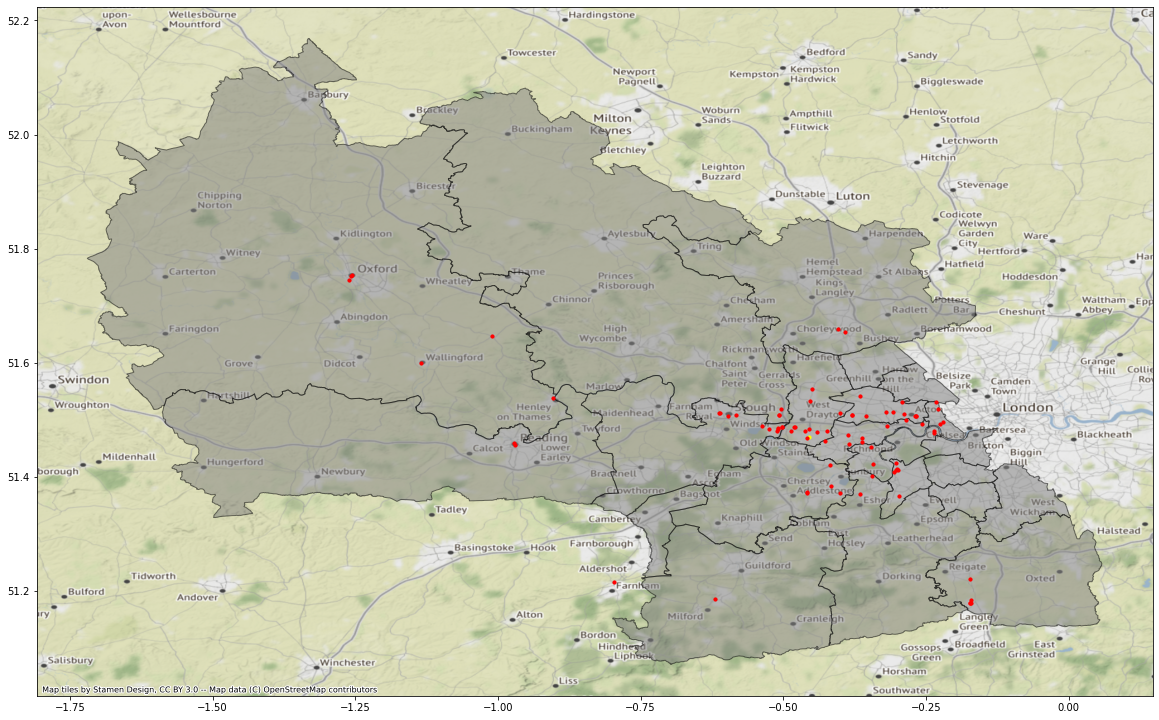

In [53]:

# limit to CCGS we have data for, instead of distance... 
# smaller_df = ldn_map_df_dist[ldn_map_df_dist['heathrow_distance'] <= 100000]
smaller_df= ldn_map_df_dist[ldn_map_df_dist['CCG_lower'].isin(lower_ccgs)]

# solution inspired by stackoverflow. can also use (long,lat) as the midpoint
# https://stackoverflow.com/questions/38899190/geopandas-label-polygons
smaller_df['coords'] = smaller_df['geometry'].apply(lambda x: x.representative_point().coords[:])
smaller_df['coords'] = [coords[0] for coords in smaller_df['coords']]


fig, ax = plt.subplots(figsize=(20,20))
smaller_df.plot(ax=ax, color='grey', alpha=0.5, edgecolor='k')
# ctx.add_basemap(ax, crs='epsg:4326', source=ctx.providers.Stamen.TonerLite)
ctx.add_basemap(ax, crs='epsg:4326')

geo_df_airport.plot(ax=ax, markersize=10, color='yellow', marker='o')
stations_geo.plot(ax=ax, markersize=10, color='red', marker='o')

# plot the names on the midpoints
# for idx, row in smaller_df.iterrows():
#     plt.annotate(s=row['CCG19NM'], xy=row['coords'],
#                  horizontalalignment='center')
    
# do the same for the airport name (complete airport_df tomorrow)    
# for idx, row in geo_df_airport.iterrows():
#     plt.annotate(s=row['LOC_NAME'], xy=((row['LONG'], row['LAT'])),
#                  horizontalalignment='center', color='yellow')


/Users/gaylej/.virtualenvs/aa_at_py3/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


<AxesSubplot:>

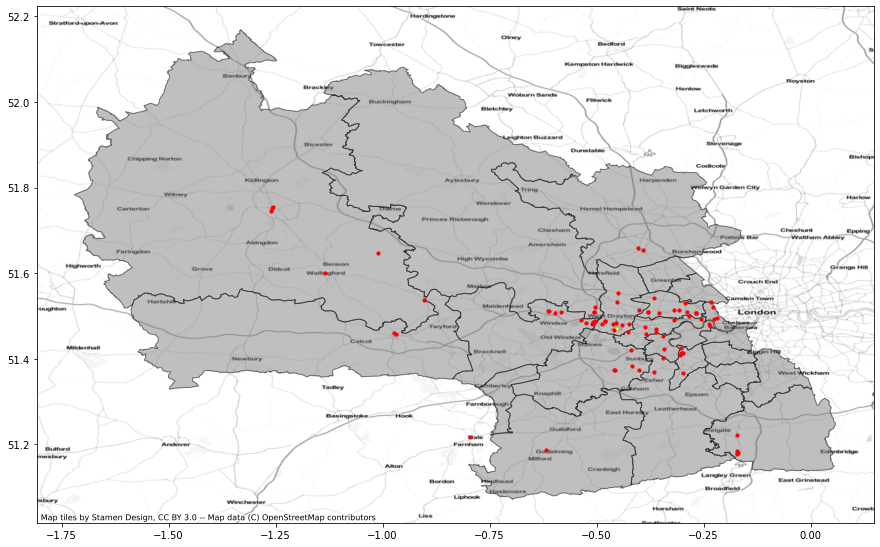

In [51]:

# limit to CCGS we have data for, instead of distance... 
# smaller_df = ldn_map_df_dist[ldn_map_df_dist['heathrow_distance'] <= 100000]
smaller_df= ldn_map_df_dist[ldn_map_df_dist['CCG_lower'].isin(lower_ccgs)]

# solution inspired by stackoverflow. can also use (long,lat) as the midpoint
# https://stackoverflow.com/questions/38899190/geopandas-label-polygons
smaller_df['coords'] = smaller_df['geometry'].apply(lambda x: x.representative_point().coords[:])
smaller_df['coords'] = [coords[0] for coords in smaller_df['coords']]


fig, ax = plt.subplots(figsize=(15,15))
smaller_df.plot(ax=ax, color='grey', alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, crs='epsg:4326', source=ctx.providers.Stamen.TonerLite,)

geo_df_airport.plot(ax=ax, markersize=10, color='yellow', marker='o')
stations_geo.plot(ax=ax, markersize=10, color='red', marker='o')

# plot the names on the midpoints
# for idx, row in smaller_df.iterrows():
#     plt.annotate(s=row['CCG19NM'], xy=row['coords'],
#                  horizontalalignment='center')
    
# do the same for the airport name (complete airport_df tomorrow)    
# for idx, row in geo_df_airport.iterrows():
#     plt.annotate(s=row['LOC_NAME'], xy=((row['LONG'], row['LAT'])),
#                  horizontalalignment='center', color='yellow')
